In [ ]:
import numpy as np # linear algebra
from numpy import array
import pandas as pd # reading of CSV file
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn import preprocessing
from google.colab import drive
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import boxcox
from scipy.sparse import csr_matrix

In [ ]:
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#read the train and test dataset
train_df = pd.read_csv("/content/gdrive/MyDrive/Capstone/train.csv")
test_df = pd.read_csv("/content/gdrive/MyDrive/Capstone/test.csv")

In [ ]:
#EDA on the train dataset

display(train_df)
train_df.info()
train_df.describe()
train_df.nunique()

# noted that there are 0 null values in the data set
# Number of unique values for categorical data ("season", "holiday", "workingday" and "weather") agrees with legend provided by data source
# hence there is no need to inpute any data.
# datetime column is in str data type. To split data into date and time (with possibility to split into day, month, year)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


datetime      10886
season            4
holiday           2
workingday        2
weather           4
temp             49
atemp            60
humidity         89
windspeed        28
casual          309
registered      731
count           822
dtype: int64

In [ ]:
#splitting the 1st column into date/time columns
train_df['Hour'] = pd.to_datetime(train_df['datetime']).dt.hour
train_df['Year'] = pd.to_datetime(train_df['datetime']).dt.year
train_df['Month'] = pd.to_datetime(train_df['datetime']).dt.month
train_df['Day'] = pd.to_datetime(train_df['datetime']).dt.day
train_df['DayofWeek'] = pd.to_datetime(train_df['datetime']).dt.weekday

test_df['Hour'] = pd.to_datetime(test_df['datetime']).dt.hour
test_df['Year'] = pd.to_datetime(test_df['datetime']).dt.year
test_df['Month'] = pd.to_datetime(test_df['datetime']).dt.month
test_df['Day'] = pd.to_datetime(test_df['datetime']).dt.day
test_df['DayofWeek'] = pd.to_datetime(test_df['datetime']).dt.weekday

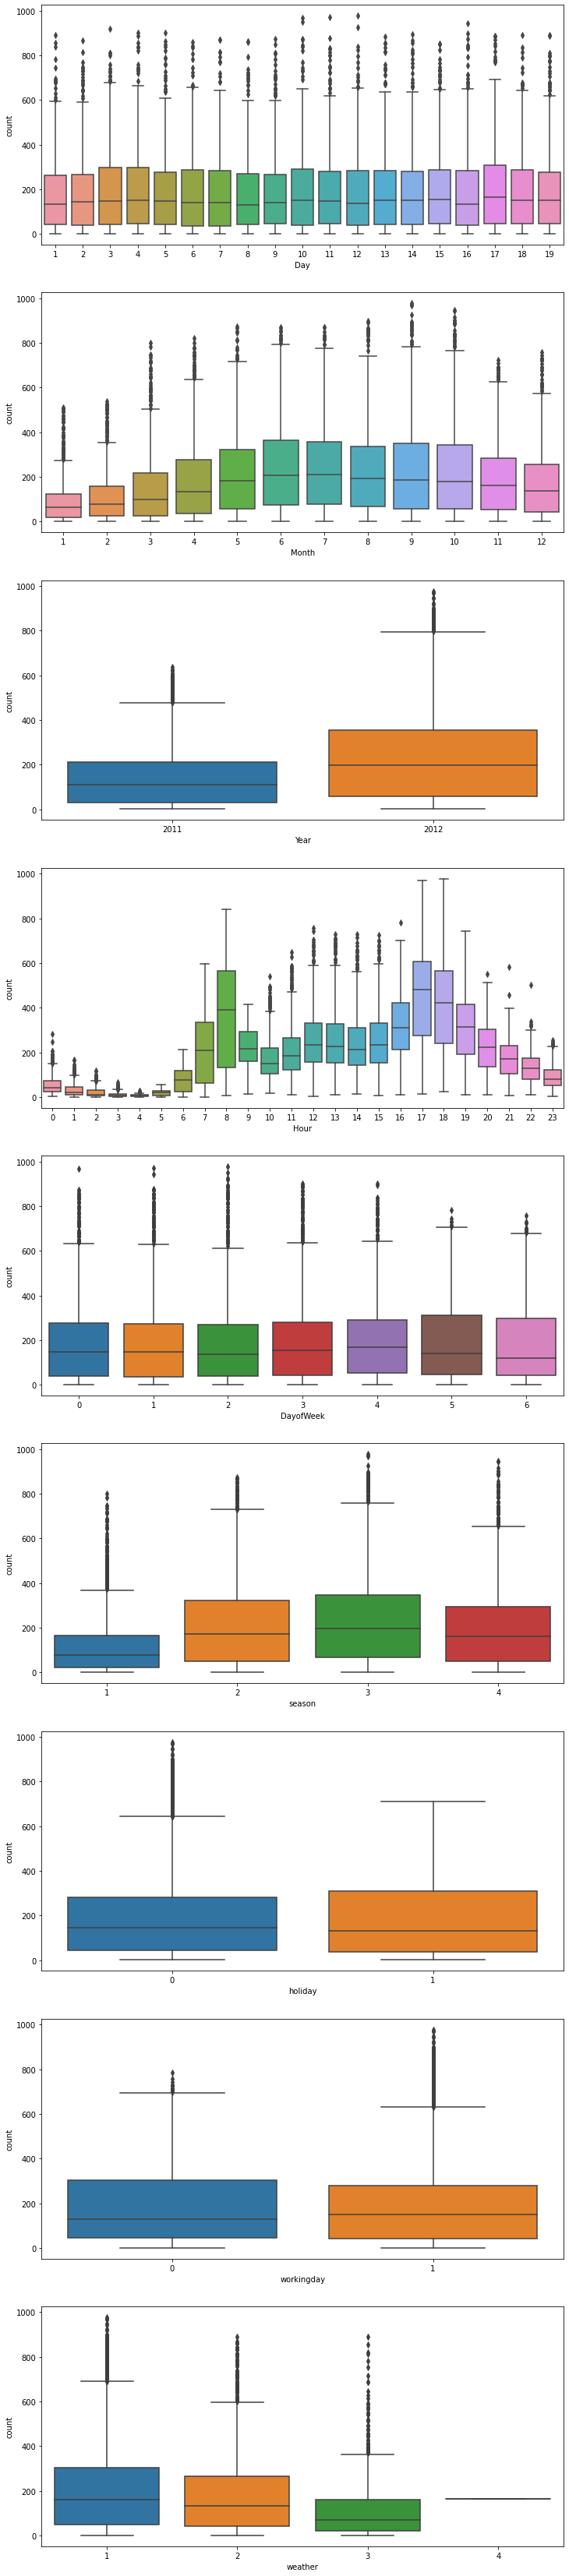

In [ ]:
fig,ax = plt.subplots(9, 1, figsize=(12, 60))

i = 0
for features in ["Day", "Month", "Year", "Hour","DayofWeek", "season", "holiday","workingday","weather"]:
  sns.boxplot(x=train_df[features],y=train_df["count"],ax=ax[i])
  i+=1

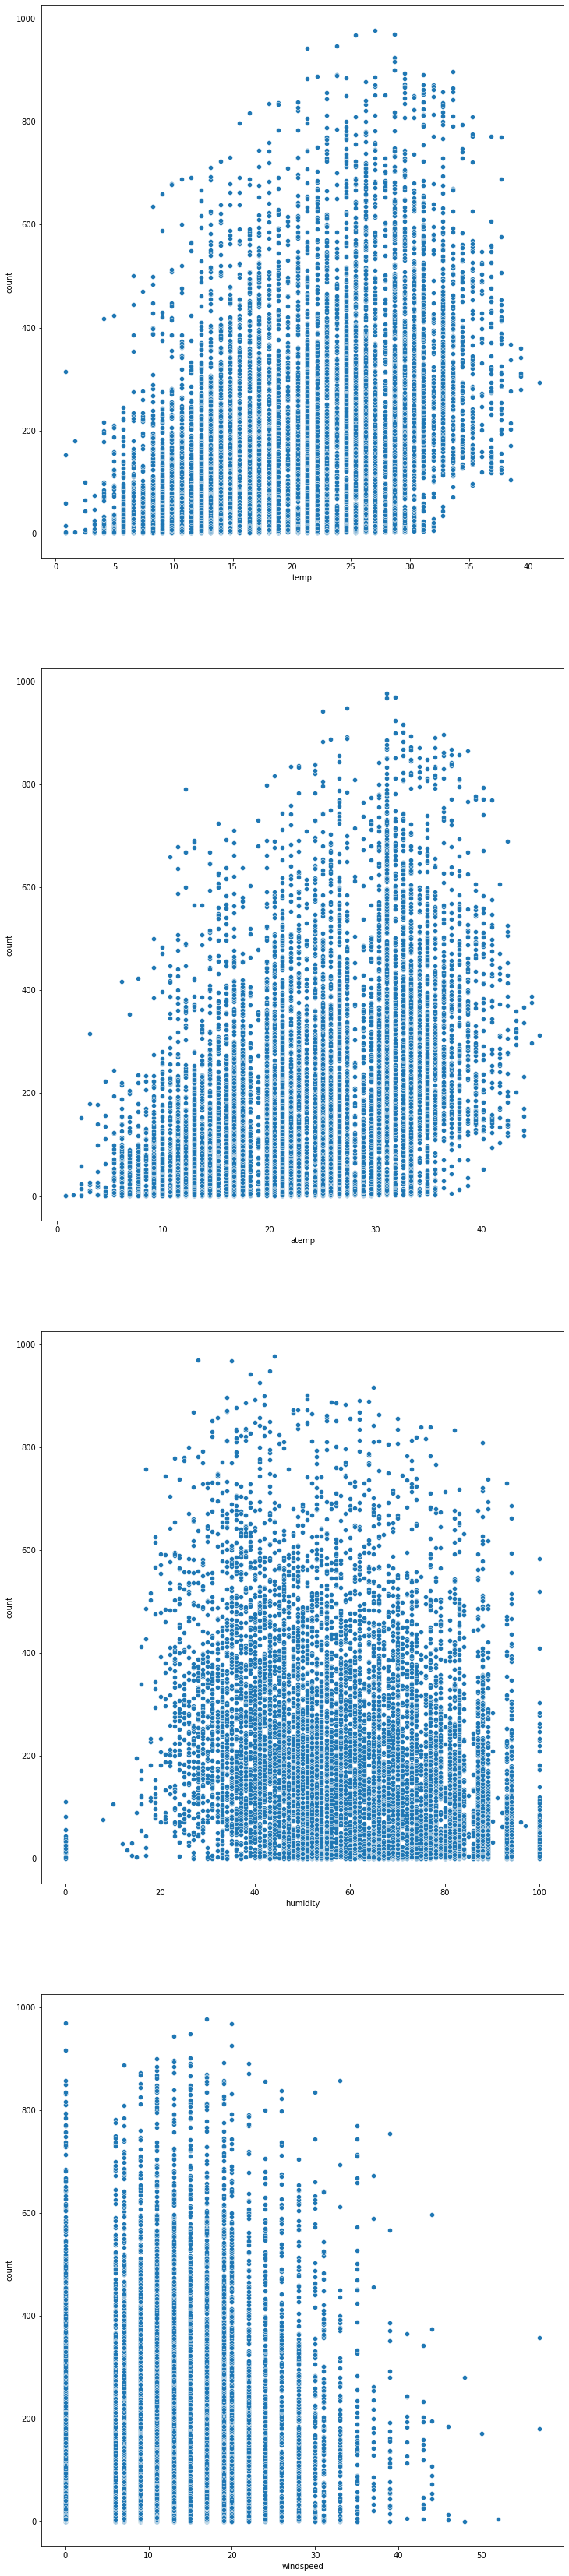

In [ ]:
fig,ax = plt.subplots(4, 1, figsize=(12, 60))

i=0

for features in ["temp", "atemp", "humidity","windspeed"]:
  sns.scatterplot(x=train_df[features], y=train_df["count"], ax = ax[i])
  i+=1

In [ ]:
print(train_df["Day"].unique())
print(test_df["Day"].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29 30 31]


Text(0.5, 1.0, 'Heat Map of the Correlation of Numerical Features')

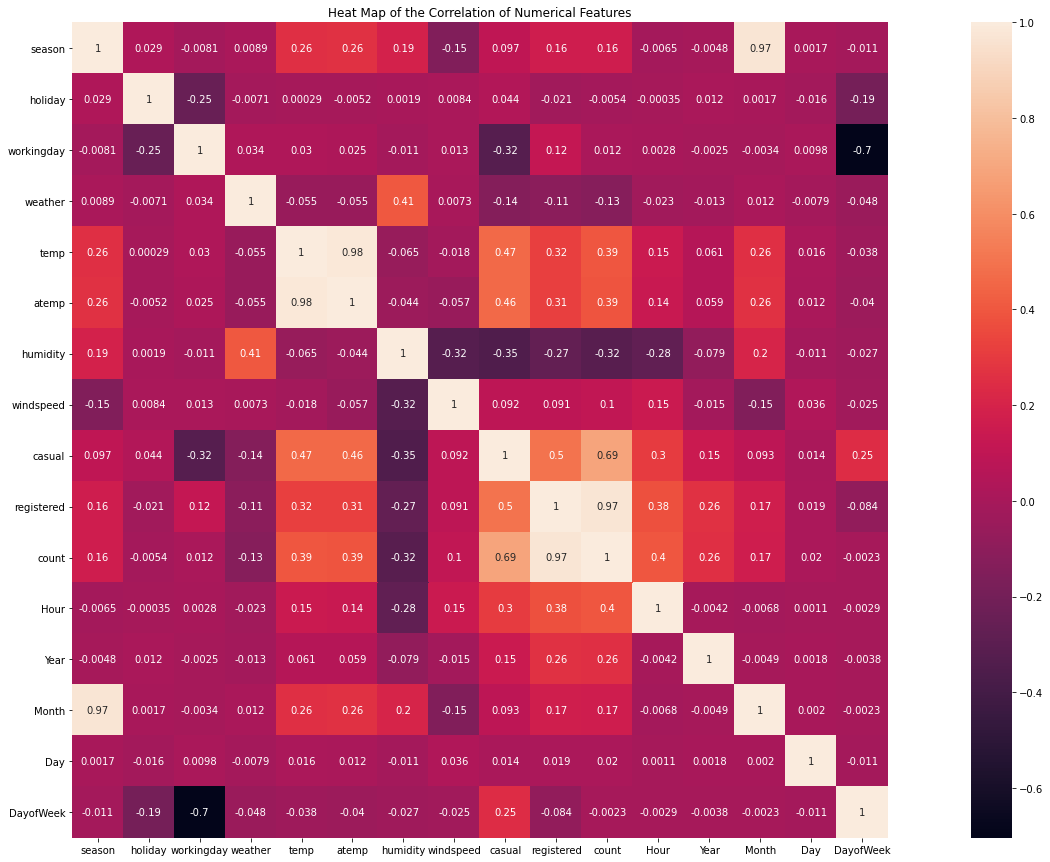

In [ ]:
corrmat = train_df.corr()

fig, ax = plt.subplots(figsize=(30, 15))

sns.heatmap(corrmat, square=True, annot = True, ax=ax);
ax.set_title ("Heat Map of the Correlation of Numerical Features")
# From the heat map, atemp has a very strong correlation temp, we can perhaps  exclude either feature in our model, 
# (suggest atemp, since feel like temperature is impacted by wind speed, temperature and humidity which information is alr captured by the other features.
# (https://blog.metoffice.gov.uk/2012/02/15/what-is-feels-like-temperature/)
# Month and seasons are also strongly correlated, can consider removing one.
# Day is irrelevant since the training dataset and test dataset have completely different days (Training = 1-19, Test = 20-31st)
# Can also consider dropping seasons since it is strongly correlated to month, and we should not be expecting much change in the seasonal change within 2 years.

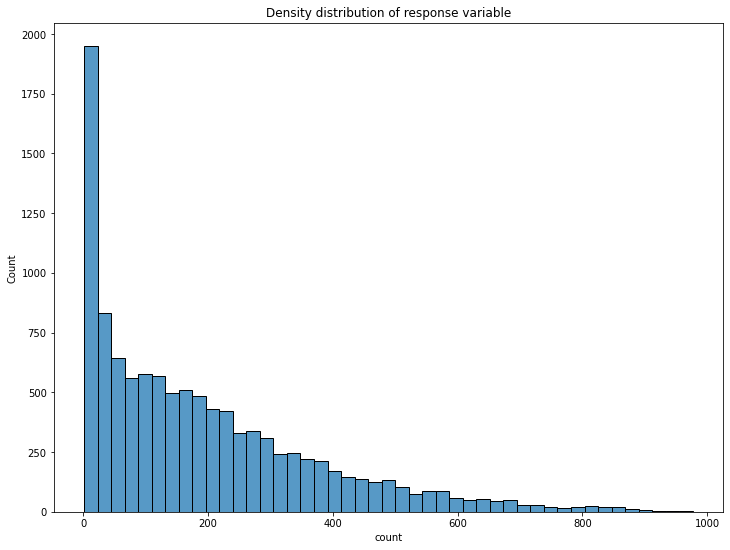

In [ ]:
#looking at the reponse variable

fig, ax = plt.subplots(figsize=(12, 9))

ax.set_title("Density distribution of response variable")

sns.histplot(train_df['count'], ax = ax)

#count distribution is skewed to right, try using log transformation and boxcox transformation of the count value to normalize the data

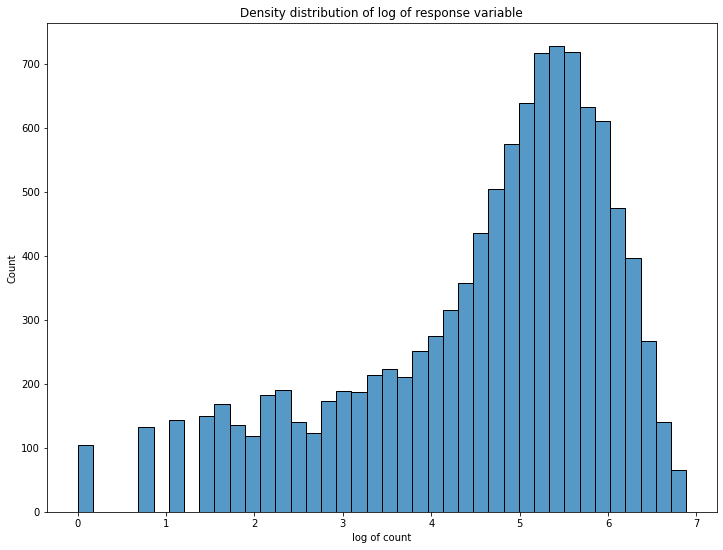

In [ ]:
# Try log transformation

log_count = np.log(train_df["count"])

fig, ax = plt.subplots(figsize=(12, 9))

ax.set_title("Density distribution of log of response variable")
ax.set_xlabel("log of count")

sns.histplot(log_count, ax = ax)

#now skew to the left

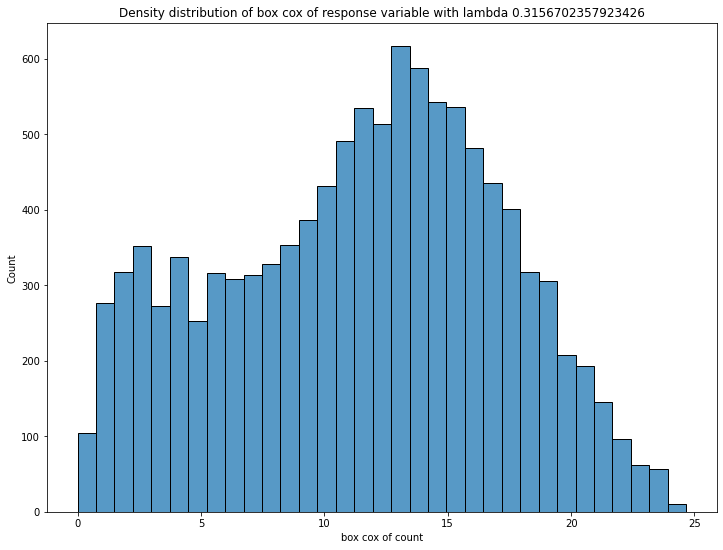

In [ ]:
#try box cox transformation

box_cox_count, max_log = boxcox(train_df["count"])

fig, ax = plt.subplots(figsize=(12, 9))

title = f"Density distribution of box cox of response variable with lambda {max_log}"

ax.set_title(title)
ax.set_xlabel("box cox of count")

sns.histplot(box_cox_count, ax = ax)

#Data is more normalized

In [ ]:
#feature engineering

#since seasons and weather are categorical data, perform one hot encoding since ordinal encoding in this case is not meaningful

#first, we convert the data type to str

def get_season (value):
    if value == 1:
        return "spring"
    if value == 2:
        return "summer"
    if value ==3:
        return "fall"
    if value ==4:
        return "winter"
    
def get_weather (value):
    if value == 1:
        return "clear"
    if value == 2:
        return 'mist'
    if value == 3:
        return 'light'
    if value == 4:
        return 'heavy'

train_df["season"] = train_df["season"].map(get_season)
train_df["weather"] = train_df["weather"].map(get_weather)

test_df["season"] = test_df["season"].map(get_season)
test_df["weather"] = test_df["weather"].map(get_weather)

In [ ]:
#one hot encoding for train data set

encoder = OneHotEncoder(handle_unknown="ignore")

encoder.fit(train_df.loc[:,["season","weather"]])
encoded_columns = encoder.transform(train_df.loc[:,["season","weather"]])

encoded_df = pd.DataFrame.sparse.from_spmatrix(encoded_columns, columns=encoder.get_feature_names(), index=train_df.index)

train_df.drop(["season","weather"], inplace = True, axis =1)
train_df = pd.concat([train_df, encoded_df],axis=1)

train_df.head()

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,Hour,Year,Month,Day,DayofWeek,x0_fall,x0_spring,x0_summer,x0_winter,x1_clear,x1_heavy,x1_light,x1_mist
0,2011-01-01 00:00:00,0,0,9.84,14.395,81,0.0,3,13,16,0,2011,1,1,5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2011-01-01 01:00:00,0,0,9.02,13.635,80,0.0,8,32,40,1,2011,1,1,5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2011-01-01 02:00:00,0,0,9.02,13.635,80,0.0,5,27,32,2,2011,1,1,5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2011-01-01 03:00:00,0,0,9.84,14.395,75,0.0,3,10,13,3,2011,1,1,5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2011-01-01 04:00:00,0,0,9.84,14.395,75,0.0,0,1,1,4,2011,1,1,5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
#one hot encoding for train data set

encoder = OneHotEncoder(handle_unknown="ignore")

encoder.fit(test_df.loc[:,["season","weather"]])
encoded_columns = encoder.transform(test_df.loc[:,["season","weather"]])

encoded_df = pd.DataFrame.sparse.from_spmatrix(encoded_columns, columns=encoder.get_feature_names(), index=test_df.index)

test_df.drop(["season","weather"], inplace = True, axis =1)
test_df = pd.concat([test_df, encoded_df],axis=1)

test_df.head()

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,Hour,Year,Month,Day,DayofWeek,x0_fall,x0_spring,x0_summer,x0_winter,x1_clear,x1_heavy,x1_light,x1_mist
0,2011-01-20 00:00:00,0,1,10.66,11.365,56,26.0027,0,2011,1,20,3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2011-01-20 01:00:00,0,1,10.66,13.635,56,0.0000,1,2011,1,20,3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2011-01-20 02:00:00,0,1,10.66,13.635,56,0.0000,2,2011,1,20,3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2011-01-20 03:00:00,0,1,10.66,12.880,56,11.0014,3,2011,1,20,3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2011-01-20 04:00:00,0,1,10.66,12.880,56,11.0014,4,2011,1,20,3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
# separate into X_train and Y_train data
# "casual" and "registered" columns excluded as they are considered a sub category of response variable
# "datetime" and "Day" is dropped as discussed above.
# try using box cox transformation for the response variable.

X_train = train_df.drop(["casual","registered","count","Day","datetime"],axis=1)
X_test = test_df.drop(["Day",'datetime'],axis=1)
y_train = train_df["count"]
y_box_cox_train = boxcox(train_df["count"])[0]

In [ ]:
#train test split on training data

X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train, y_train, test_size = 0.3, random_state= 100)

X_box_cox_train_train, X_box_cox_train_test, y_box_cox_train_train, y_box_cox_train_test = train_test_split(X_train, y_box_cox_train, test_size = 0.3, random_state= 100)

In [ ]:
# Now, we try initializing and fitting the Linear Regression model on the given data with the 3 different response variable models.

lm = LinearRegression()
lm_box_cox = LinearRegression()

lm.fit(X_train_train, y_train_train)
lm_box_cox.fit(X_box_cox_train_train, y_box_cox_train_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
#compare the accuracy of the 3 different model
y_train_train_pred = lm.predict(X_train_train)
y_box_cox_train_train_pred = lm_box_cox.predict(X_box_cox_train_train)

print(f"rMSE: {np.sqrt(mean_squared_error(y_train_train, y_train_train_pred))}")
print(f"R-Squared: {r2_score(y_train_train, y_train_train_pred)}")

print(f"box cox rMSE: {np.sqrt(mean_squared_error(y_box_cox_train_train, y_box_cox_train_train_pred))}")
print(f"box cox R-Squared: {r2_score(y_box_cox_train_train, y_box_cox_train_train_pred)}")

# Comapring the 2 models, using box cox transformation of 'Count' yields better accuracy due to higher R squared value.
# However, generally the R squared value using linear model is low. Hence we try other model.

rMSE: 141.3130663531198
R-Squared: 0.3952073320575532
box cox rMSE: 3.9847843860184513
box cox R-Squared: 0.4955113268873096


In [ ]:
#Try using decision tree model on original dataset

dt = DecisionTreeRegressor()

dt.fit(X_train_train, y_train_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
y_dt_train_train_pred = dt.predict(X_train_train)

print(f"rMSE: {np.sqrt(mean_squared_error(y_train_train, y_dt_train_train_pred))}")
print(f"R-Squared: {r2_score(y_train_train, y_dt_train_train_pred)}")

# deicison tree has a much better bias with R squared score of 0.999.
# now we look at the variance

rMSE: 0.42579245249114644
R-Squared: 0.9999945091725664


In [ ]:
y_dt_train_test_pred = dt.predict(X_train_test)

print(f"rMSE: {np.sqrt(mean_squared_error(y_train_test, y_dt_train_test_pred))}")
print(f"R-Squared: {r2_score(y_train_test, y_dt_train_test_pred)}")

# high value of 0.893, showing the model may give good prediction (low variance)
# however, can we further improve this model?? Try omitting certain features

rMSE: 61.174258942255356
R-Squared: 0.8841957210398967


In [ ]:
# As discussed above, try dropping temp and seasons

X_train_train_simple = X_train_train.drop(["atemp", "x0_fall", "x0_spring", "x0_summer", "x0_winter"], axis=1)
X_train_test_simple = X_train_test.drop(["atemp", "x0_fall", "x0_spring", "x0_summer", "x0_winter"], axis=1)

dt_simple = DecisionTreeRegressor()
dt_simple.fit(X_train_train_simple, y_train_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
#Checking bias
y_dt_train_train_simple_pred = dt_simple.predict(X_train_train_simple)

print(f"rMSE: {np.sqrt(mean_squared_error(y_train_train, y_dt_train_train_simple_pred))}")
print(f"R-Squared: {r2_score(y_train_train, y_dt_train_train_simple_pred)}")


#Checking variance
y_dt_train_test_simple_pred = dt_simple.predict(X_train_test_simple)

print(f"rMSE: {np.sqrt(mean_squared_error(y_train_test, y_dt_train_test_simple_pred))}")
print(f"R-Squared: {r2_score(y_train_test, y_dt_train_test_simple_pred)}")

# variance improved with R squared value now 0.907 with no sacrifice to the bias (Still 0.999)

rMSE: 0.42579245249114644
R-Squared: 0.9999945091725664
rMSE: 62.3542397069397
R-Squared: 0.8796851735099476


In [ ]:
display(X_test.head())
display(X_train_train_simple.head())

,holiday,workingday,temp,atemp,humidity,windspeed,Hour,Year,Month,DayofWeek,x0_fall,x0_spring,x0_summer,x0_winter,x1_clear,x1_heavy,x1_light,x1_mist
0,0,1,10.66,11.365,56,26.0027,0,2011,1,3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,1,10.66,13.635,56,0.0000,1,2011,1,3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,1,10.66,13.635,56,0.0000,2,2011,1,3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0,1,10.66,12.880,56,11.0014,3,2011,1,3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,1,10.66,12.880,56,11.0014,4,2011,1,3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


,holiday,workingday,temp,humidity,windspeed,Hour,Year,Month,DayofWeek,x1_clear,x1_heavy,x1_light,x1_mist
8414,0,1,28.70,58,16.9979,23,2012,7,2,0.0,0.0,0.0,1.0
6601,0,1,13.94,61,8.9981,8,2012,3,0,1.0,0.0,0.0,0.0
530,0,0,8.20,100,0.0000,6,2011,2,5,0.0,0.0,1.0,0.0
4725,0,1,15.58,87,0.0000,23,2011,11,2,1.0,0.0,0.0,0.0
6727,0,0,25.42,53,6.0032,14,2012,3,5,1.0,0.0,0.0,0.0


In [ ]:
#Using the final model obtain, we use it to predict the given test data set

predictions =  dt_simple.predict(X_test.drop(["atemp", "x0_fall", "x0_spring", "x0_summer", "x0_winter"], axis=1))

predictions = pd.DataFrame(predictions)

pred=predictions.merge(test_df["datetime"], left_index=True, right_index=True)

pred.set_index("datetime", inplace=True)

pred.rename({0:"count"}, axis = 1, inplace = True)

pred.to_csv("/content/gdrive/MyDrive/Capstone/predictions.csv", index=True, header=True)

# New Section